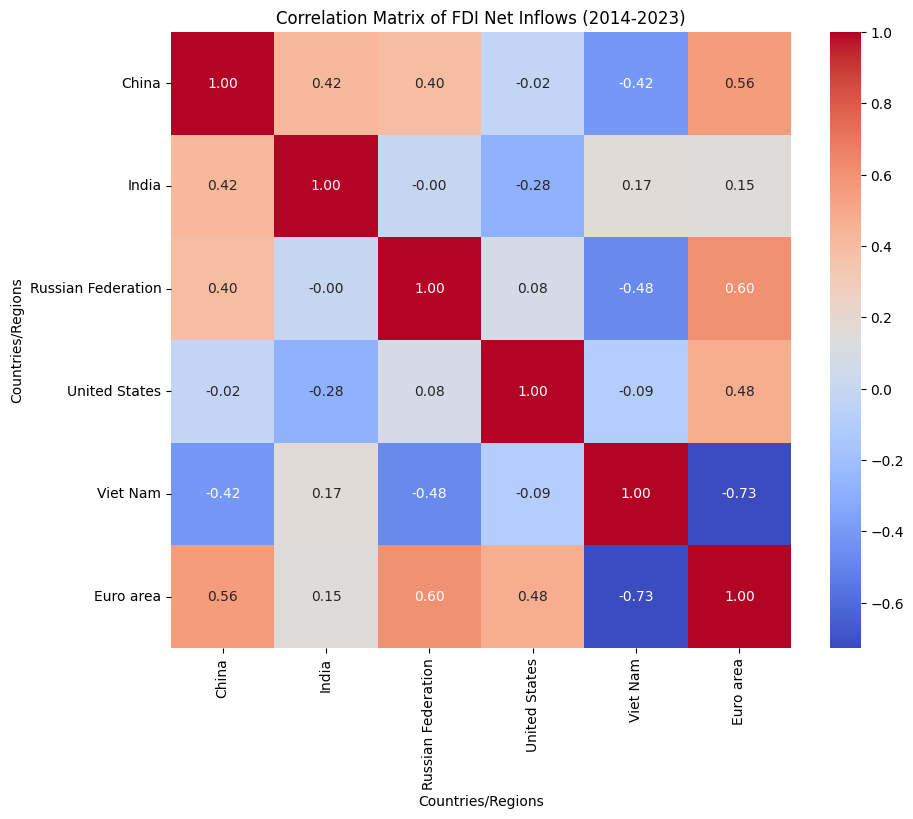


Correlation of FDI in Vietnam with other countries/regions:
Country Name
Viet Nam              1.000000
India                 0.170951
United States        -0.093406
China                -0.416342
Russian Federation   -0.475167
Euro area            -0.727065
Name: Viet Nam, dtype: float64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'FDI_10yrs.csv'
df = pd.read_csv(file_path)

# Data Cleaning and Preparation
# Remove rows with all NaN values
df.dropna(how='all', inplace=True)
# Remove metadata rows (assuming they can be identified by missing 'Country Name' or specific strings)
df = df[~df['Country Name'].isin(['Data from database', 'Last Updated: 01/28/2025', None])]
df = df.dropna(subset=['Country Name'])

# Select relevant columns and rename year columns
years_cols = [col for col in df.columns if '[YR' in col]
selected_cols = ['Country Name'] + years_cols
df_fdi = df[selected_cols].copy()

# Rename year columns to just year numbers
year_names = [col.split('[YR')[-1].split(']')[0] for col in years_cols]
year_rename_dict = dict(zip(years_cols, year_names))
df_fdi.rename(columns=year_rename_dict, inplace=True)

# Convert year columns to numeric
for year in year_names:
    df_fdi[year] = pd.to_numeric(df_fdi[year], errors='coerce')

# Set 'Country Name' as index and transpose to have years as index and countries as columns
df_fdi.set_index('Country Name', inplace=True)
df_fdi_transposed = df_fdi.transpose()

# Calculate the correlation matrix
correlation_matrix = df_fdi_transposed.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of FDI Net Inflows (2014-2023)')
plt.xlabel('Countries/Regions')
plt.ylabel('Countries/Regions')
plt.show()

# Analyze correlation with Vietnam (VNM)
vietnam_correlations = correlation_matrix['Viet Nam'].sort_values(ascending=False)
print("\nCorrelation of FDI in Vietnam with other countries/regions:")
print(vietnam_correlations)

In [17]:
import pandas as pd
import warnings
from statsmodels.tsa.stattools import grangercausalitytests

warnings.simplefilter("ignore")
# Load the CSV file
file_path = 'FDI_10yrs.csv'
df = pd.read_csv(file_path)

# Data Cleaning and Preparation
# Remove rows with all NaN values
df.dropna(how='all', inplace=True)
# Remove metadata rows
df = df[~df['Country Name'].isin(['Data from database', 'Last Updated: 01/28/2025', None])]
df = df.dropna(subset=['Country Name'])

# Select relevant columns and rename year columns
years_cols = [col for col in df.columns if '[YR' in col]
selected_cols = ['Country Name'] + years_cols
df_fdi = df[selected_cols].copy()

# Rename year columns to just year numbers
year_names = [col.split('[YR')[-1].split(']')[0] for col in years_cols]
year_rename_dict = dict(zip(years_cols, year_names))
df_fdi.rename(columns=year_rename_dict, inplace=True)

# Convert year columns to numeric
for year in year_names:
    df_fdi[year] = pd.to_numeric(df_fdi[year], errors='coerce')

# Set 'Country Name' as index and transpose to have years as index and countries as columns
df_fdi.set_index('Country Name', inplace=True)
df_fdi_transposed = df_fdi.transpose()

# Granger Causality Test Function
def perform_granger_causality(series1, series2, maxlag=2, verbose=False):
    """
    Performs Granger causality test.

    Parameters:
    series1: Time series 1 (pandas Series).
    series2: Time series 2 (pandas Series).
    maxlag: Maximum lag to consider in the test.
    verbose: If True, prints detailed test results.

    Returns:
    dict: Dictionary of Granger causality test results.
          Returns None if test cannot be performed.
    """
    data = pd.DataFrame({'s1': series1, 's2': series2}).dropna()
    if len(data) < 3: # Need at least 3 data points for grangercausalitytests with maxlag=2
        return None

    try:
        results = grangercausalitytests(data[['s2', 's1']], maxlag=maxlag, verbose=verbose)
        return results
    except Exception as e:
        print(f"Error during Granger causality test: {e}")
        return None


# Analyze Granger Causality with Vietnam (VNM)
vietnam_fdi = df_fdi_transposed['Viet Nam']
countries = [col for col in df_fdi_transposed.columns if col != 'Viet Nam']
max_lag = 2 # Considering max lag of 2 due to limited data points
significance_level = 0.05

print("Granger Causality Analysis with Vietnam FDI:\n")

for country in countries:
    country_fdi = df_fdi_transposed[country]

    # Test if country Granger-causes Vietnam
    gc_country_to_vn_results = perform_granger_causality(vietnam_fdi, country_fdi, maxlag=max_lag, verbose=False)
    if gc_country_to_vn_results:
        p_value_country_to_vn = gc_country_to_vn_results[max_lag][0]['ssr_ftest'][1]
        if p_value_country_to_vn < significance_level:
            causality_country_to_vn = "YES"
        else:
            causality_country_to_vn = "NO"
    else:
        causality_country_to_vn = "INCONCLUSIVE (Not enough data)"
        p_value_country_to_vn = "N/A"


    # Test if Vietnam Granger-causes country
    gc_vn_to_country_results = perform_granger_causality(country_fdi, vietnam_fdi, maxlag=max_lag, verbose=False)
    if gc_vn_to_country_results:
        p_value_vn_to_country = gc_vn_to_country_results[max_lag][0]['ssr_ftest'][1]
        if p_value_vn_to_country < significance_level:
            causality_vn_to_country = "YES"
        else:
            causality_vn_to_country = "NO"
    else:
        causality_vn_to_country = "INCONCLUSIVE (Not enough data)"
        p_value_vn_to_country = "N/A"


    print(f"Country: {country}")
    print(f"  Does {country} Granger-cause Viet Nam FDI? {causality_country_to_vn} (p-value: {p_value_country_to_vn})")
    print(f"  Does Viet Nam Granger-cause {country} FDI? {causality_vn_to_country} (p-value: {p_value_vn_to_country})")
    print("-" * 50)


print("\nInterpretation:")
print(f"* Significance level used: {significance_level}")
print("* 'YES' indicates that we reject the null hypothesis of no Granger causality at the chosen significance level.")
print("* 'NO' indicates we fail to reject the null hypothesis.")
print("* 'INCONCLUSIVE' suggests that the test could not be reliably performed, possibly due to insufficient data points after handling missing values for a given pair.")
print("* Granger causality does not imply true causation, but rather predictive precedence.")

Granger Causality Analysis with Vietnam FDI:

Country: China
  Does China Granger-cause Viet Nam FDI? NO (p-value: 0.5202806307726926)
  Does Viet Nam Granger-cause China FDI? NO (p-value: 0.7299359509795144)
--------------------------------------------------
Country: India
  Does India Granger-cause Viet Nam FDI? NO (p-value: 0.32198844128482734)
  Does Viet Nam Granger-cause India FDI? YES (p-value: 0.013034263445456853)
--------------------------------------------------
Country: Russian Federation
  Does Russian Federation Granger-cause Viet Nam FDI? NO (p-value: 0.43611912565773797)
  Does Viet Nam Granger-cause Russian Federation FDI? NO (p-value: 0.8929423458676816)
--------------------------------------------------
Country: United States
  Does United States Granger-cause Viet Nam FDI? NO (p-value: 0.8834154669190696)
  Does Viet Nam Granger-cause United States FDI? NO (p-value: 0.2984217685104299)
--------------------------------------------------
Country: Euro area
  Does Euro

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# Đọc dữ liệu từ file CSV
data_path = "FDI_10yrs.csv"
df = pd.read_csv(data_path)

# Kiểm tra thông tin dữ liệu
print(df.head())
print(df.info())

# Chuyển đổi cột thời gian nếu có
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])  # Cột đầu tiên là thời gian

# Xác định danh sách quốc gia/khu vực (bỏ cột thời gian)
countries = df.columns[1:]

# Hàm kiểm tra tính dừng của chuỗi thời gian
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # True nếu chuỗi dừng (p-value < 0.05)

# Hàm chạy mô hình VAR giữa VN và từng quốc gia/khu vực
def var_analysis(target_country):
    print(f"\n==== Phân tích VAR giữa VN và {target_country} ====")
    
    # Lấy dữ liệu của VN và quốc gia cần phân tích
    data_subset = df[['Vietnam', target_country]].dropna()
    
    # Kiểm tra tính dừng, nếu không dừng thì lấy sai phân bậc 1
    for col in data_subset.columns:
        if not check_stationarity(data_subset[col]):
            data_subset[col] = data_subset[col].diff().dropna()
    
    # Huấn luyện mô hình VAR
    model = VAR(data_subset.dropna())
    results = model.fit(maxlags=5, ic='aic')
    
    # In summary
    print(results.summary())
    
    # Kiểm tra quan hệ nhân quả Granger
    print("\nGranger Causality Test:")
    granger_test = grangercausalitytests(data_subset.dropna(), maxlag=5, verbose=True)
    
    # Vẽ IRF (Impulse Response Function)
    irf = results.irf(10)
    irf.plot(orth=True)
    plt.show()

# Phân tích từng quốc gia/khu vực
for country in countries:
    if country != 'Vietnam':
        var_analysis(country)


                                         Series Name        Series Code  \
0  Foreign direct investment, net inflows (BoP, c...  BX.KLT.DINV.CD.WD   
1  Foreign direct investment, net inflows (BoP, c...  BX.KLT.DINV.CD.WD   
2  Foreign direct investment, net inflows (BoP, c...  BX.KLT.DINV.CD.WD   
3  Foreign direct investment, net inflows (BoP, c...  BX.KLT.DINV.CD.WD   
4  Foreign direct investment, net inflows (BoP, c...  BX.KLT.DINV.CD.WD   

         Country Name Country Code  2014 [YR2014]  2015 [YR2015]  \
0               China          CHN   2.680972e+11   2.424893e+11   
1               India          IND   3.457664e+10   4.400949e+10   
2  Russian Federation          RUS   2.203134e+10   6.852970e+09   
3       United States          USA   2.518560e+11   5.114340e+11   
4            Viet Nam          VNM   9.200000e+09   1.180000e+10   

   2016 [YR2016]  2017 [YR2017]  2018 [YR2018]  2019 [YR2019]  2020 [YR2020]  \
0   1.747496e+11   1.660838e+11   2.353651e+11   1.871698e+1

C:\Users\Admin\AppData\Local\Temp\ipykernel_21932\1468325474.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])  # Cột đầu tiên là thời gian


DateParseError: Unknown datetime string format, unable to parse: Foreign direct investment, net inflows (BoP, current US$), at position 0

Stationarity Check (ADF Test):

ADF Test for: Viet Nam
ADF Statistic: 2.934122
p-value: 1.000000
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616
Viet Nam is likely non-stationary.
--------------------------------------------------
ADF Test for: United States
ADF Statistic: 1.843498
p-value: 0.998431
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
United States is likely non-stationary.
--------------------------------------------------
ADF Test for: Russian Federation
ADF Statistic: 0.155166
p-value: 0.969632
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614
Russian Federation is likely non-stationary.
--------------------------------------------------
ADF Test for: China
ADF Statistic: -0.345820
p-value: 0.918760
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602
China is likely non-stationary.
--------------------------------------------------
ADF Test for: India
ADF Statistic: 3.780008
p-value: 1.000000
Critical Values:
	1%: -3.589
	5%: -2.930
	10%: -2.603
India i

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<Figure size 1200x800 with 0 Axes>

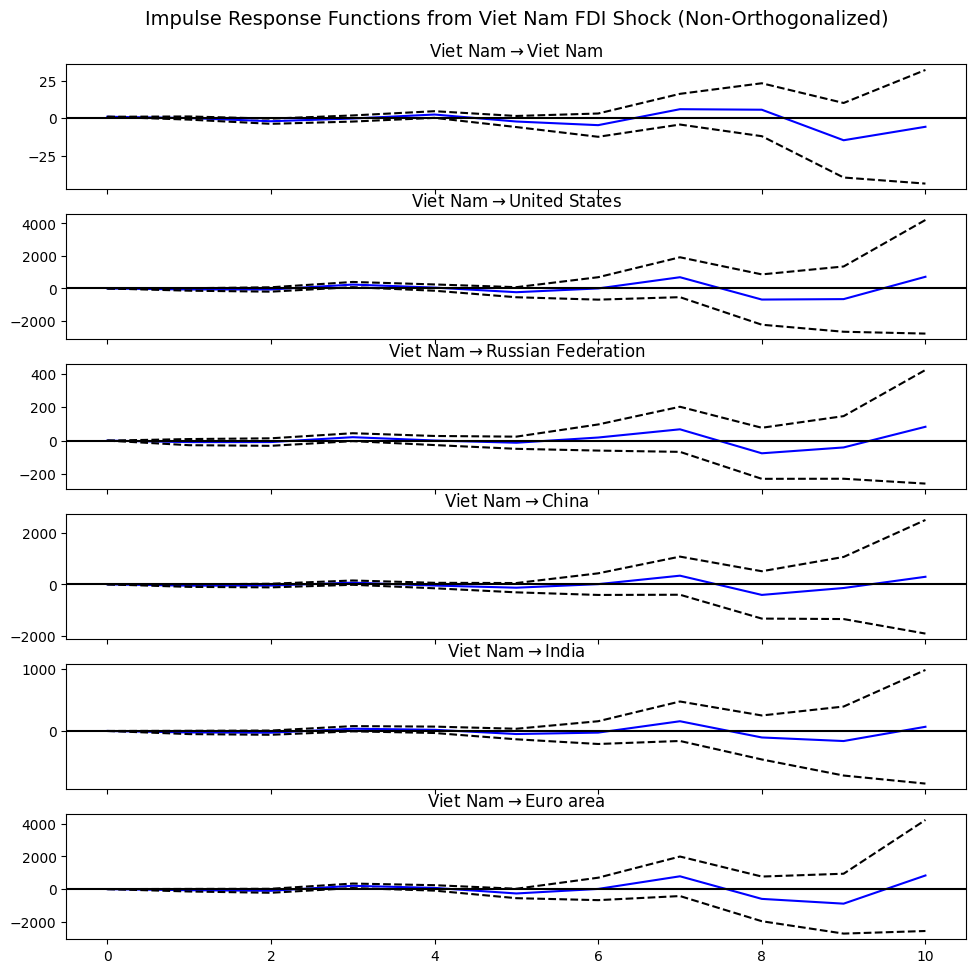

FEVD for Viet Nam
     Viet Nam  United States  Russian Federation     China     India  Euro area
0    1.000000       0.000000            0.000000  0.000000  0.000000   0.000000
1    0.863318       0.014744            0.012900  0.000404  0.068599   0.040034
2    0.788787       0.014755            0.034652  0.028294  0.098806   0.034706
3    0.746138       0.024721            0.045887  0.029540  0.093440   0.060273
4    0.909366       0.010582            0.015248  0.011320  0.032861   0.020623
5    0.838380       0.024278            0.013373  0.012412  0.044555   0.067003
6    0.909134       0.009634            0.006711  0.021728  0.022160   0.030633
7    0.899658       0.010098            0.004815  0.025290  0.028116   0.032023
8    0.931733       0.004286            0.004753  0.011188  0.025487   0.022552
9    0.927558       0.015415            0.002414  0.010450  0.016957   0.027206

FEVD for United States
     Viet Nam  United States  Russian Federation     China     India  Euro are

<Figure size 1200x800 with 0 Axes>

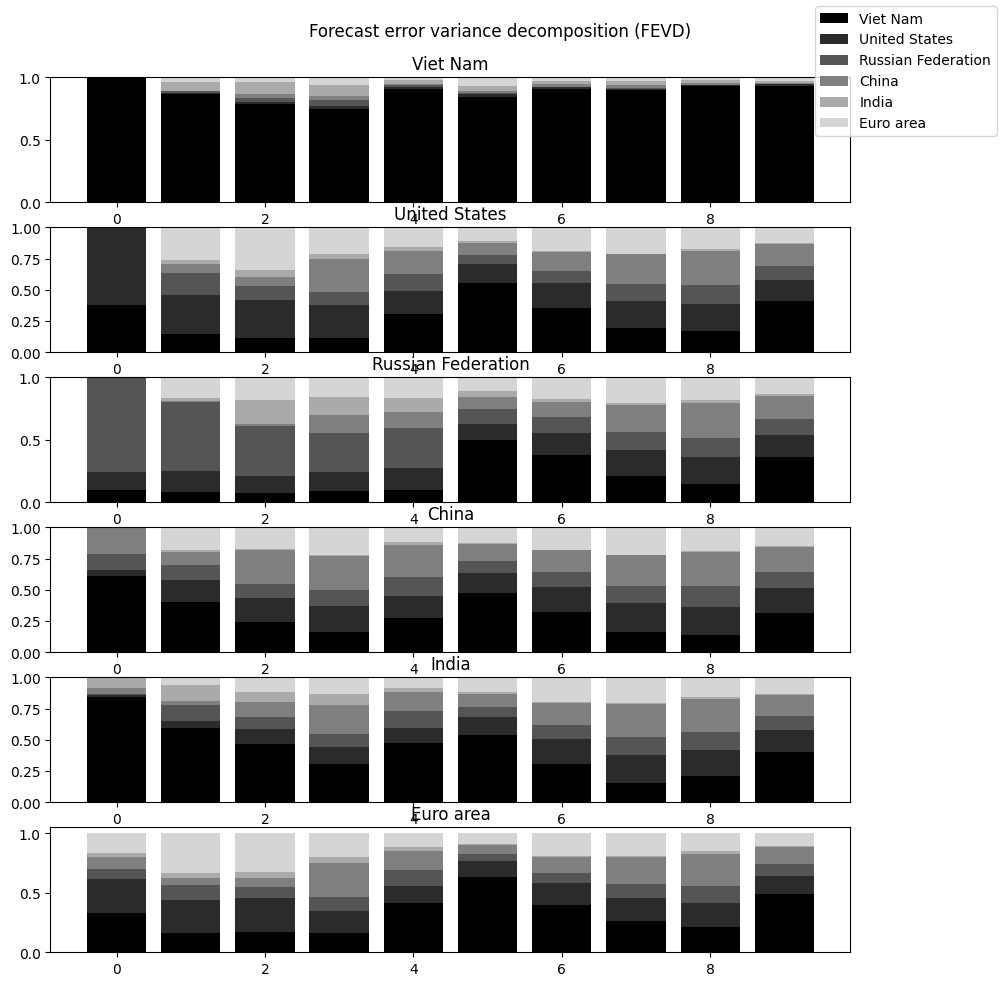


Interpretation of VAR Analysis:
* Stationarity Check: ADF test is used to check if the time series are stationary. P-value <= 0.05 suggests stationarity.
* Differencing: If series are non-stationary, first differencing is applied to make them stationary.
* Lag Order Selection: Information criteria (AIC, BIC, HQIC) are used to select the optimal lag order for the VAR model.
* VAR Model Summary: Provides coefficients, standard errors, t-stats, and p-values for each equation in the VAR model.
* Impulse Response Functions (IRF): Show how a shock to FDI in Viet Nam affects FDI in other countries over time. Orthogonalized IRF is used to account for contemporaneous correlations.
* Forecast Error Variance Decomposition (FEVD): Shows the proportion of the forecast error variance of Viet Nam FDI that is explained by shocks to FDI in each country.
* Caution: VAR results are based on statistical relationships and do not imply causation. While 50 years of data is better, VAR results should still b

In [20]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'FDI_50yrs.csv'
df = pd.read_csv(file_path)

# Data Cleaning and Preparation
# Remove rows with all NaN values
df.dropna(how='all', inplace=True)
# Remove metadata rows
df = df[~df['Country Name'].isin(['Data from database', 'Last Updated: 01/28/2025', None])]
df = df.dropna(subset=['Country Name'])

# Select relevant columns and rename year columns
years_cols = [col for col in df.columns if '[YR' in col]
selected_cols = ['Country Name'] + years_cols
df_fdi = df[selected_cols].copy()

# Rename year columns to just year numbers
year_names = [col.split('[YR')[-1].split(']')[0] for col in years_cols]
year_rename_dict = dict(zip(years_cols, year_names))
df_fdi.rename(columns=year_rename_dict, inplace=True)

# Convert year columns to numeric
for year in year_names:
    df_fdi[year] = pd.to_numeric(df_fdi[year], errors='coerce')

# Set 'Country Name' as index and transpose to have years as index and countries as columns
df_fdi.set_index('Country Name', inplace=True)
df_fdi_transposed = df_fdi_transposed.apply(pd.to_numeric, errors='coerce')
df_fdi_transposed = df_fdi.transpose()
df_fdi_transposed.index = pd.to_datetime(df_fdi_transposed.index, format='%Y') # Ensure index is datetime for VAR


# Stationarity Check using ADF test
def check_stationarity(series, country_name):
    result = adfuller(series.dropna()) # dropna() to handle potential NaNs in stationarity test
    print(f'ADF Test for: {country_name}')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print(f"{country_name} is likely stationary.")
        return True
    else:
        print(f"{country_name} is likely non-stationary.")
        return False

print("Stationarity Check (ADF Test):\n")
is_stationary = {}
for country in df_fdi_transposed.columns:
    is_stationary[country] = check_stationarity(df_fdi_transposed[country], country)
    print("-" * 50)

# If not stationary, difference the series (First differencing)
df_fdi_diff = df_fdi_transposed.diff().dropna() # dropna() to remove the first row with NaN after differencing
print("\nStationarity Check after First Differencing (ADF Test):\n")
is_stationary_diff = {}
for country in df_fdi_diff.columns:
    is_stationary_diff[country] = check_stationarity(df_fdi_diff[country], country)
    print("-" * 50)

# Select data for VAR model - using differenced data if original is not stationary
print("is_stationary.values():", list(is_stationary.values())) # Print as a list to see the boolean values
data_for_var = df_fdi_diff if not all(is_stationary.values()) else df_fdi_transposed

# Order Selection for VAR model
model = VAR(data_for_var)
lag_order_results = model.select_order(maxlags=3) # Check up to lag 3 - Adjusted back to 3, can try higher if needed
print('\nVAR Order Selection:')
print(lag_order_results.summary())
optimal_lag = lag_order_results.aic # Using AIC for lag order selection, can change to bic or hqic

# Fit VAR model
model_fitted = model.fit(optimal_lag)
print('\nVAR Model Summary:')
print(model_fitted.summary())

# Impulse Response Analysis (Non-Orthogonalized)
irf = model_fitted.irf(periods=10) # Calculate NON-orthogonalized IRF (remove orth=True)
plt.figure(figsize=(12,8))
irf.plot(impulse='Viet Nam')
plt.suptitle('Impulse Response Functions from Viet Nam FDI Shock (Non-Orthogonalized)', fontsize=14) # Update title
plt.show()

# Forecast Error Variance Decomposition (FEVD)
fevd = model_fitted.fevd(periods=10) # FEVD for 10 periods
fevd.summary()

plt.figure(figsize=(12,8))
fevd.plot()
plt.show()
 # FEVD for Viet Nam FDI, showing contributions from each country

print("\nInterpretation of VAR Analysis:")
print("* Stationarity Check: ADF test is used to check if the time series are stationary. P-value <= 0.05 suggests stationarity.")
print("* Differencing: If series are non-stationary, first differencing is applied to make them stationary.")
print("* Lag Order Selection: Information criteria (AIC, BIC, HQIC) are used to select the optimal lag order for the VAR model.")
print("* VAR Model Summary: Provides coefficients, standard errors, t-stats, and p-values for each equation in the VAR model.")
print("* Impulse Response Functions (IRF): Show how a shock to FDI in Viet Nam affects FDI in other countries over time. Orthogonalized IRF is used to account for contemporaneous correlations.")
print("* Forecast Error Variance Decomposition (FEVD): Shows the proportion of the forecast error variance of Viet Nam FDI that is explained by shocks to FDI in each country.")
print("* Caution: VAR results are based on statistical relationships and do not imply causation. While 50 years of data is better, VAR results should still be interpreted cautiously.")